In [ ]:
import torch

import os

from shap_e.diffusion.sample import sample_latents
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.notebooks import create_pan_cameras, decode_latent_images, gif_widget
from sae.sae import SAE, train_sae
import matplotlib.pyplot as plt

from shap_e.util.notebooks import decode_latent_mesh
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.manual_seed(42)
hook_handles = []

Using device: cuda


In [3]:
torch.manual_seed(42)
# Load all files from the 'trout' directory as tensors

if input("Do you want to train the SAE? (y/n): ") == "yes":
    loadmode = {0: "both", 1: "first", 2: "second"}[2]

    if loadmode == "both":
        activation_files = [os.path.join("trout", f) for f in os.listdir("trout") if f.endswith('.pt')]
        activation = torch.cat([torch.load(f).to(device) for f in activation_files], dim=0)
        reshaped_data = activation.reshape(-1, 1024*1026)
    else:
        activation_files = [os.path.join("trout", f) for f in os.listdir("trout") if f.endswith('.pt') and loadmode in f]
        activation = torch.cat([torch.load(f).to(device) for f in activation_files], dim=0)
        reshaped_data = activation.reshape(-1, 1024*1026)

    print(reshaped_data.shape)

    sae_model = SAE(input_dim=1024*1026, hidden_dims=[256,128], latent_dim=64).to(device)
    losses = train_sae(sae_model, reshaped_data, num_epochs=500, sparsity_weight=0.1, patience=50, lr=1e-3, batch_size=400)
    torch.save(sae_model.state_dict(), 'sae/sae_model2.pt')
else:
    sae_model = SAE(input_dim=1024*1026, hidden_dims=[256,128], latent_dim=64).to(device)
    sae_model.load_state_dict(torch.load("sae/sae_model2.pt"))
    sae_model.to(device)
    print("Loaded SAE model")

Loaded SAE model


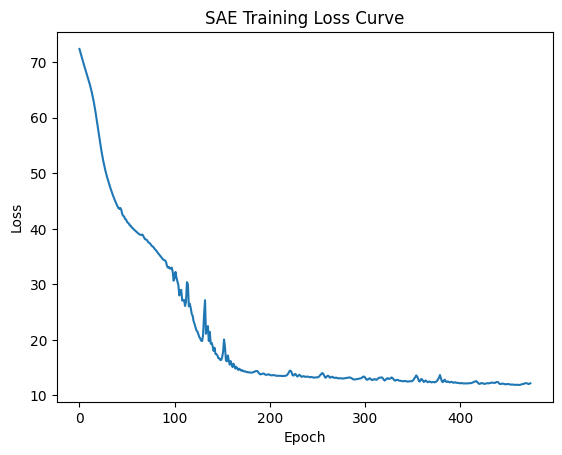

In [4]:
plt.plot(losses[25:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SAE Training Loss Curve')
plt.show()

In [4]:
xm = load_model('transmitter', device=device)
model = load_model('text300M', device=device)
diffusion = diffusion_from_config(load_config('diffusion'))

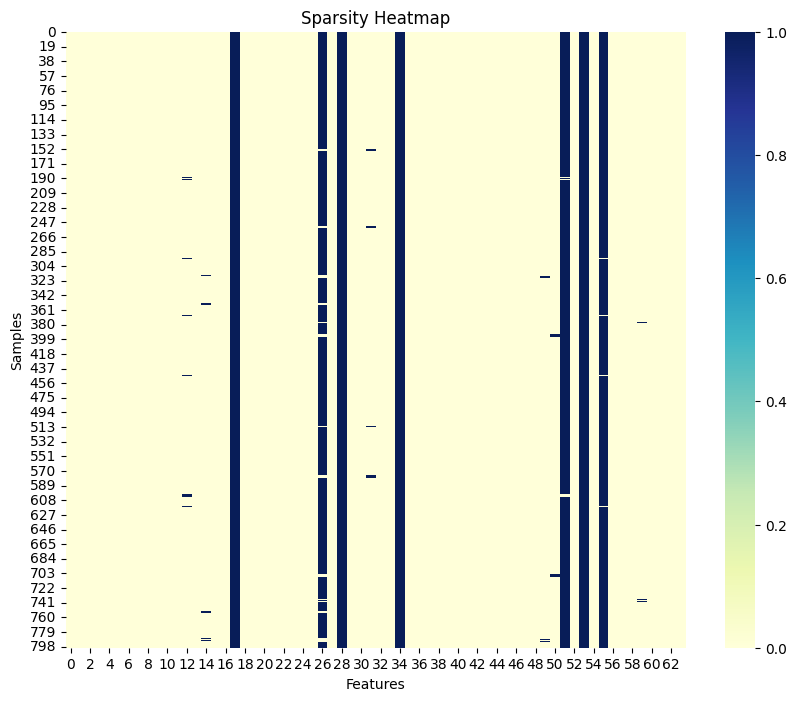

In [8]:
import seaborn as sns

#sparsity testing

activation_files = [os.path.join("trout", f) for f in os.listdir("trout") if f.endswith('.pt')]
activation = torch.cat([torch.load(f).to(device) for f in activation_files], dim=0)

reshaped_data = activation.reshape(-1, 1024*1026)

lat = sae_model.get_sparse_vector(reshaped_data,k = 7)

spacs = []

for i in range(reshaped_data.shape[0]):
    sparseactivations = [int(i.item()) for i in lat[i] != 0]
    spacs.append(sparseactivations)

spacs = torch.tensor(spacs, dtype=torch.int)
# Plot the sparsity pattern as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spacs.cpu().numpy(), cmap="YlGnBu", cbar=True)
plt.title("Sparsity Heatmap")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()

hot_indices = [17,26,28,34,51,53,55]

In [ ]:
# data generation
from tqdm import tqdm

file = open("sae/prompts.txt", "r")
prompts = file.read().split("\n")
file.close()

batch_size = 2
guidance_scale = 15.0

for prompt in tqdm(prompts[40:]):
    latents = sample_latents(
    batch_size=batch_size,
    model=model,
    diffusion=diffusion,
    guidance_scale=guidance_scale,
    model_kwargs=dict(texts=[prompt] * batch_size),
    progress=False,
    clip_denoised=True,
    noise=None,
    use_fp16=True,
    use_karras=True,
    karras_steps=32,
    sigma_min=1e-3,
    sigma_max=160,
    s_churn=0,
)

100%|██████████| 60/60 [16:19<00:00, 16.33s/it]


In [ ]:
#hook
#2 = lat
#1 = reshaped_data
#0 = none


def my_hook(module, input, output):
    if output[1] == 16:
        print("hook")
        reshaped_data = output[0].reshape(-1, 1024*1026)
        lat = sae_model.get_sparse_vector(reshaped_data,k = 10)
        print(lat[0][17])
        lat[0][17] = 0
        return sae_model.decode(lat).reshape(output[0].shape), 16


hook_handles.append(model.wrapped.backbone.resblocks[-1].register_forward_hook(my_hook))

In [17]:
batch_size = 1
guidance_scale = 15.0
prompt = "white spinning chair"

latents = sample_latents(
    batch_size=batch_size,
    model=model,
    diffusion=diffusion,
    guidance_scale=guidance_scale,
    model_kwargs=dict(texts=[prompt] * batch_size),
    progress=True,
    clip_denoised=True,
    noise=None,
    use_fp16=True,
    use_karras=True,
    karras_steps=32,
    sigma_min=1e-3,
    sigma_max=160,
    s_churn=0,
)

  0%|          | 0/32 [00:00<?, ?it/s]

hook
tensor(-186.8750, device='cuda:0', dtype=torch.float16)


In [5]:
def clear_hooks():
    for hook_handle in hook_handles:
        hook_handle.remove()

In [13]:
def render(prt, ind):
    folder = f'plys/{"_".join(prt.split(" "))}_{ind}'
    os.makedirs(folder, exist_ok=True)

    for i, latent in enumerate(latents):
        t = decode_latent_mesh(xm, latent).tri_mesh()
        with open(f'{folder}/{"_".join(prt.split(" "))}_{ind}_{i}.ply', 'wb') as f:
            t.write_ply(f)

In [15]:
#mess withg latspace
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
batch_size = 1
guidance_scale = 15.0

file = open("sae/prompts.txt", "r")
prompts = file.read().split("\n")
file.close()

prompts = ["blue office chair"] + prompts[:10]
hot_indices = [17,26,28,34,51,53,55]
# for prompt in prompts:
for index in hot_indices:

    # index = hot_indices[0]
    prompt = prompts[0]

    latentslist = []

    for i in tqdm(range(-4,6)):
        clear_hooks()
        def my_hook(module, input, output):
            if output[1] == 16:
                reshaped_data = output[0].reshape(-1, 1024*1026)
                lat = sae_model.get_sparse_vector(reshaped_data,k = 10)
                incr = lat[0][index]/5
                lat[0][index] = lat[0][index] - i * incr
                return sae_model.decode(lat).reshape(output[0].shape), 16

        
        hook_handles.append(model.wrapped.backbone.resblocks[-1].register_forward_hook(my_hook))

        latentslist.append(sample_latents(
            batch_size=batch_size,
            model=model,
            diffusion=diffusion,
            guidance_scale=guidance_scale,
            model_kwargs=dict(texts=[prompt] * batch_size),
            progress=False,
            clip_denoised=True,
            noise=None,
            use_fp16=True,
            use_karras=True,
            karras_steps=32,
            sigma_min=1e-3,
            sigma_max=160,
            s_churn=0,
        ))

    latents = torch.cat(latentslist, dim=0)

    render(prompt, index)

    

100%|██████████| 10/10 [01:21<00:00,  8.12s/it]


In [ ]:
render_mode = 'nerf' # you can change this to 'stf'
size = 128 # this is the size of the renders; higher values take longer to render.

cameras = create_pan_cameras(size, device)
for i, latent in enumerate(latents):
    
    images = decode_latent_images(xm, latent, cameras, rendering_mode=render_mode)
    display(gif_widget(images))

In [13]:
torch.cuda.empty_cache()

/home/Elia/shap-e_with_SAE/shap_e/models/stf/renderer.py:286: UserWarning: exception rendering with PyTorch3D: No module named 'pytorch3d'
  warnings.warn(f"exception rendering with PyTorch3D: {exc}")
/home/Elia/shap-e_with_SAE/shap_e/models/stf/renderer.py:287: UserWarning: falling back on native PyTorch renderer, which does not support full gradients
  warnings.warn(
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f43aabc5f60>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


FileNotFoundError: [Errno 2] No such file or directory: 'plys/white_spinning_chair/white_spinning_chair_4.ply'